# Exploratory Data Analysis

## Proposal Amendment

Before diving into the Exploratory Data Analysis, I'd like to make a brief amendment to my proposal, slightly altering and then narrowing down the details of my project.

### Questions
- Stellar Flares Question: *Can we estimate the energy emitted by a flare?*
- My Question: *Can we identify whether a given point on a PDCSAP time series is a part of a flare?*

### Methods
- **Pre-treatment:** ARIMA model imputation of missing values + Detrending

**ARIMA models** are classic time series models, fitted according to the autocorrelation between values across time. Their forecasts provide a simple, robust method for imputing missing values. **Detrending** methods (e.g. backfitting, STL, etc.) will help reduce the variation that needs to be accounted for by the model, hopefully improving their predictions. However, it is possible that excessive detrending might absorb lower energy flares.

- **Model:** Isolation Forest (IF) + Time-dependent Cross-Validation (CV)

**Isolation Forests** refer to a tree-based method specialized for outlier detection. They are non-parametric and do not require labelled data. They may be less sensitive to low energy flares, but this might be improved with some feature engineering (e.g. rollign mean, standard deviation, first derivative, etc.). **Time-dependent CV** methods will help with hyperparameter tuning while respecting autocorrelation between observations.

- **Model evaluation:** Flare simulation + Baseline model comparison

**Simulating flares** in a real PDCSAP time series will provide a controlled setting with which the model can be evaluated. Varying the parameters of the simulated flares will further allow for estimation of the model sensitivity, especially valuable to observe with respect to flare intensity. **Baseline models** like sigma-clipping/Z-score methods will provide a benchmark for our model.

- **Exploration:** IF Anomaly Scores

**IF anomaly scores** provide a continuous response rather than binary classification of points as flare/no flare, akin to soft vs. hard labelling. This could be used to define a "flare confidence threshold" using the relative values of anomaly scores in the area surrounding observations above the classifiation threshold.

## Exploratory Data Analysis

For this project, we will focus on the M dwarf TIC 031381302, as done with the related paper. The date ranges analyzed in the paper are different, but this will give us a benchmark for our model.

To get familiar with the data, we will load it using pandas library, get a distribution of values, take a look at the time series as a whole, and then start looking at patterns in the data.

In [1]:
## Libraries
# lightkurve: import lightkurve as lk
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import seaborn as sns

In [2]:
## Data
df = pd.read_csv("../0.Data/031381302.csv")
# Check
print(df.shape) #df.info() # Omitted for report space

(17719, 24)


In [3]:
## Time Series of interest
pdcsap = df.loc[:, ["time", "pdcsap_flux"]]
pdcsap.info()#; print(pdcsap.shape); pdcsap.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17719 entries, 0 to 17718
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         17719 non-null  float64
 1   pdcsap_flux  17033 non-null  float64
dtypes: float64(2)
memory usage: 277.0 KB


In [4]:
## NaNs/Nulls
nulls = pdcsap.isnull().sum(); print(nulls)

time             0
pdcsap_flux    686
dtype: int64


### Comments

Thankfully, there are no missing time values, but there seem to be nearly 700 missing flux values. During pre-treatment, we will need to explore whether we can avoid imputing them. If imputation is needed, we could utilize a trend-based forecast, perhaps an ARIMA model.

## Distribution

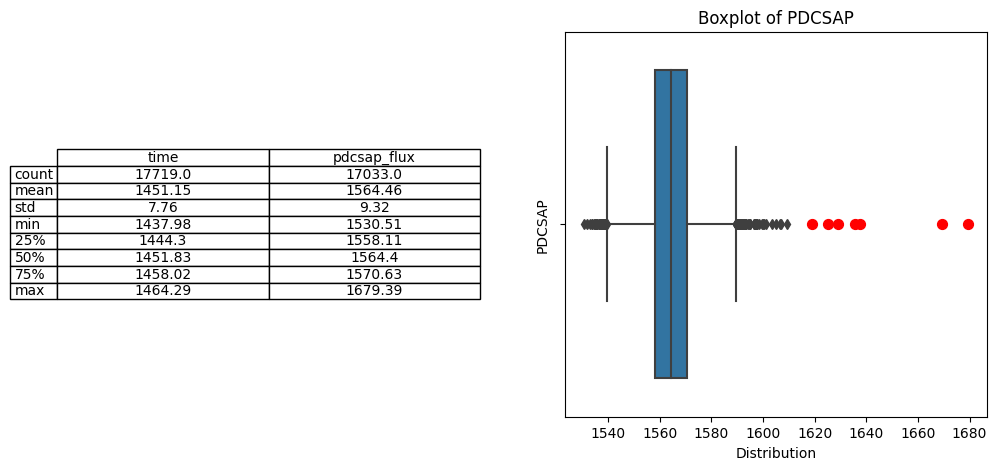

In [ ]:
## Distribution
from IPython.display import Image
Image("../1.Figures/EDA_distribution.png")

### Comments

Normal sigma-clipping models would begin by performing detrending and then classifying consecutive observations outside a certain number of standard deviations as flares. I assume that first step would reduce the variation seen in the above boxplot, leaving some of the greater outliers to the right, perhaps flagging those identified in red.

## Holistic View: PDCSAP flux over Time

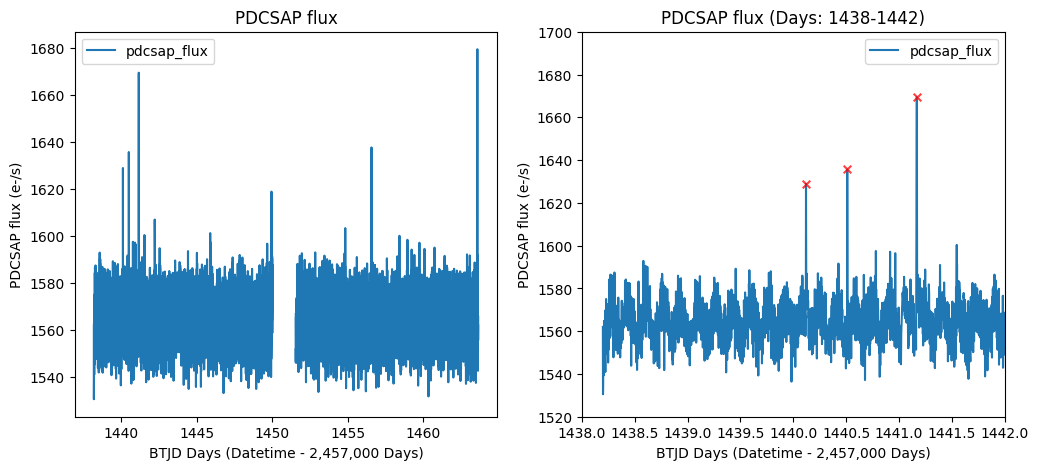

In [14]:
## Set "time" as index
pdcsap.set_index("time", inplace=True)
Image("../1.Figures/EDA_TS.png")

### Comments

On the left, we have a holistic view of the time series with some clear outliers, and potential flares. However, this view is noisy. The right plot zooms into the date range 1438-1442 to get a more granular look. Immediately, we can see that there are some larger spikes in the data, flagged in red, as well as some smaller spikes in between, any or all of which could very well correspond to flares. Additionally, there is clearly some sort of oscillating pattern appearing to occur roughly 3 times a day.

## Autocorrelation and Frequency

The time series does not appear to be white noise, but it may or may not have consistent behaviour over time, i.e. stationarity. To check this, we apply the Augmented Dickey-Fuller (ADF) unit root test, where $H_0:$ non-stationary (integrated), meaning the time series would be inconsistent over time.

In [ ]:
## Stationarity
from statsmodels.tsa.stattools import adfuller
result = adfuller(pdcsap["pdcsap_flux"].dropna()) # ADF
print(f"ADF Statistic: {result[0]}"); print(f"P-value: {result[1]}")

ADF Statistic: -30.346393685302296
P-value: 0.0


### Comments

Interestingly, the Augemented Dickey-Fuller (ADF) test returns a negative test statistic and a very small p-value. This provides evidence against $H_0$, that the time series is non-stationary. In other words, it suggests that the time series is stationary, having consistent behaviour over time.

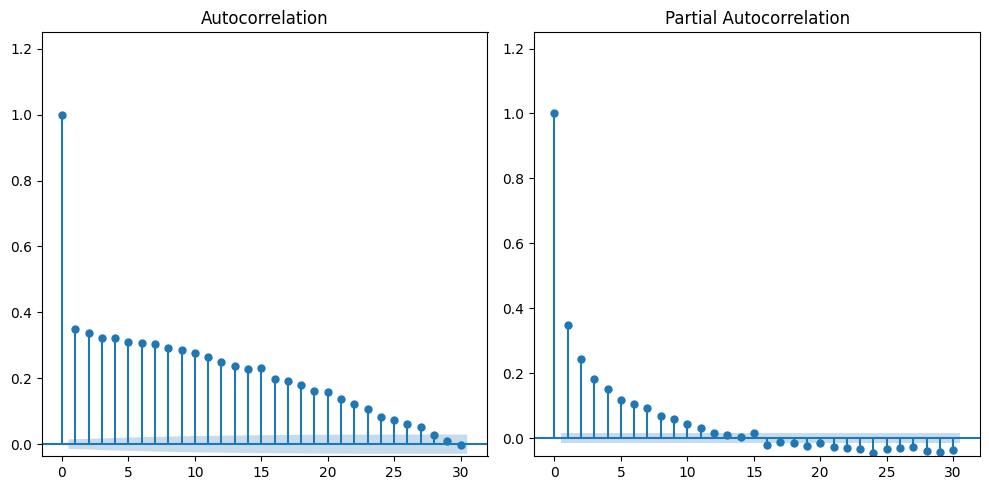

In [15]:
## Autocorrelation
Image("../1.Figures/EDA_autocorrelation.png")

### Comments

In the **autocorrelation plot** (correlogram) on the left, we see a gradual decline over time (lags). This slow decline suggests the presence of a long-term dependence structure. If we were using an ARIMA model, this would recommend a moving average (MA) component. The **partial autocorrelation plot** on the right also shows a gradual decline, indicating the presence of an autoregressive (AR) component. Hence, an ARMA model might be applicable here. This could be useful for imputing missing values.

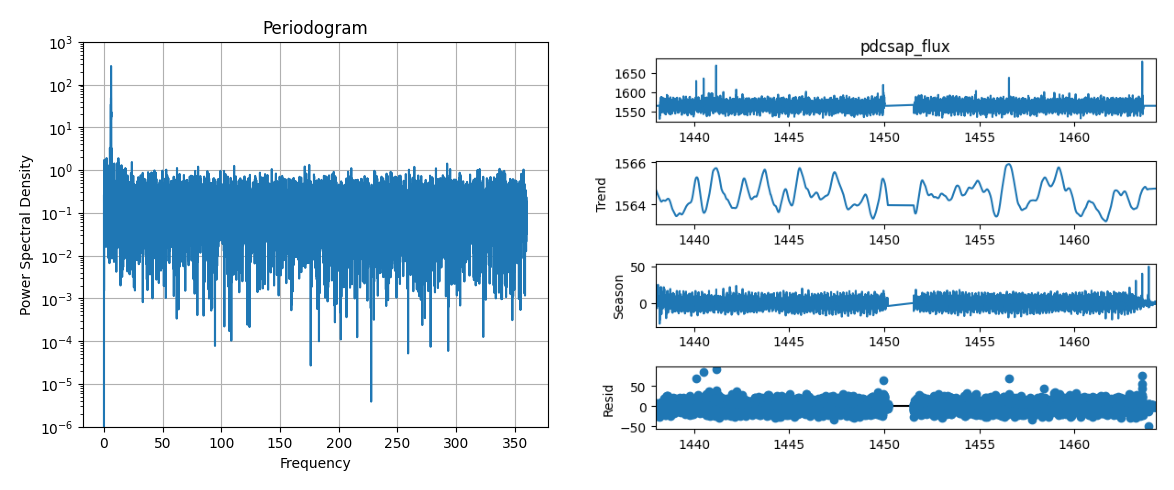

In [16]:
## Periodogram + STL Decomposition
Image("../1.Figures/EDA_periodogram_STL.png")

### Comments

The left plot shows a **periodogram** with the most noticable peaks occur at low frequencies, suggesting the presence of a long-term trend or low-frequency variations. Based on the ADF test and autocorrelation plots, I'd lean towards the latter. However, the lack of sharp periodic peaks suggests no clearly evident cyclical behaviour, which also appears visible in our earlier line plot.

In the **STL decomposition** on the right, the seasonal component appears to capture repeating patterns with a 240-observation period. This warrants further investigation during model building. The trend component appears somewhat smooth, indicating a possible underlying trend. However, given the periodogram and ADF test, I'd lean towards these being low-frequency variations. Lastly, there appear to be outliers in the residuals. These could very well reflect some of the medium-high energy flares flagged earlier.